# Coffee Review Cleaning and EDA

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

%matplotlib inline

pd.set_option('display.max_columns', 50)


# Read in raw data
df = pd.read_csv('data/raw-roast-reviews.csv')

def split_price_currency(df):
    """Split Price column into a column of the value and the currency"""
    curr_pat = r'\$?(\d+\.\d+|\d+)'
    price = df['Price']
    df['Price'] = price.apply(lambda x: re.search(curr_pat, str(x)).group(1) if re.search(curr_pat, str(x)) else None)
    df['Currency'] = price.apply(lambda x: re.sub(curr_pat, '', str(x)) if re.search(curr_pat, str(x)) else str(x)).str.strip()
    return df

def currency_clean(df):
    """Transform currency symbols to ISO 4217 codes, and clean up"""
    
    curr_map = {'#': 'GBP', '£':'GBP', '¥': 'CNY', '':'USD', 'pesos':'MXN', 'RMB':'CNY'}
    
    df.loc[(df['Currency'] == '$') | (df['Currency'].str.lower().str.contains('us', na=False)), 'Currency'] = 'USD'
    df.loc[df['Currency'].str.lower().str.contains('nt', na=False), 'Currency'] = 'TWD'
    df['Currency'] = (df['Currency']
                      .str.replace('$', '')
                      .replace(curr_map)
                      .str.strip()
                     )
    return df

def create_quantity_and_units(df):
    """Separate Amount column into a quantity and the units for that quantity. Then 
       converts all quantities to grams."""
    
    amount_pat = r'([\d.]+)\s*([a-zA-Z]+)'
    curr_pat = r'(\d+\.\d+)'

    def convert_to_grams(df):
        
        # Define conversion factors
        pound_to_gram = 453.59
        ounce_to_gram = 28.3495
        
        df.loc[df['Unit'] == 'ounces', 'Quantity'] = df['Quantity'] * ounce_to_gram
        df.loc[df['Unit'] == 'pounds', 'Quantity'] = df['Quantity'] * pound_to_gram
        
        df['Unit'] = 'grams'
        return df
                        
    return (df
            .assign(Quantity = df['Amount'].str.extract(amount_pat)[0],
                     Unit = df['Amount'].str.extract(amount_pat)[1],
                    )
            .drop('Amount', axis=1)
            .astype({'Quantity': 'float'})
            .pipe(convert_to_grams)
            .dropna(subset=['Quantity'])
            )

def create_price_USD(df):
    """Create a column converting all prices to USD using recent exchange rates."""
    exchange_rate_map = {'TWD' : 0.03, 
                         'CNY': 0.03, 
                         'GBP': 1.27, 
                         'AED':0.27, 
                         'KRW': 0.000752,
                         'HKD':0.13, 
                         'CAD': 0.74,
                         'MXN': 0.06,
                         'IDR': 0.000065,
                         'AUD': 0.65,
                         'USD': 1.0}
    df['Price_USD'] = np.round(df['Price'] * df['Currency'].map(exchange_rate_map), 2)
    return df

def tweak_coffee(df):
    return (df
            # Remove spaces from column names
            .rename(columns = lambda c: c.replace(' ', '_'))
            .rename(columns = {'Coffee_Origin': 'Origin',
                               'Est._Price': 'Price'})
            # Remove duplicates based on roaster and name of roast
            .drop_duplicates(subset=['Roaster', 'Coffee_Name'])
            # Clean up columns. Create datetime column from Review_Date. Split Agtron into two columns.
            # Split Price into a column for cost and a column for amount and unit. 
            .assign(Review_Date = pd.to_datetime(df['Review_Date'], format='%b %Y'),
                    Acidity = lambda df_: df_['Acidity/Structure'].fillna(df_['Acidity']),
                    Agtron_External = lambda df_: df_['Agtron'].str.split('/', expand=True)[0],
                    Agtron_Ground = lambda df_: df_['Agtron'].str.split('/', expand=True)[1],
                    Amount = lambda df_: df_['Price'].str.split('/', expand=True)[1],
                    Price = lambda df_: df_['Price'].str.replace(',', '').str.split('/', expand=True)[0],
                     )
            # Remove whitespace and tranform "NA" to NaN
            .applymap(lambda x: x.strip() if isinstance(x, str) else x)
            .applymap(lambda x: np.nan if x == 'NA' else x)
            # Split price value and currency 
            .pipe(split_price_currency)
            # Clean up currency and standardize
            .pipe(currency_clean)
            # Drop old columns and rows with missing values
            .drop(['Acidity/Structure', 'Agtron',], axis=1)
            .dropna(subset=['Acidity', 'Roast_Level', 'Aroma', 'Price', 'Bottom_Line', 
                            'Agtron_External', 'Agtron_Ground',])
            # Separate unit of measurment from quantity
            .pipe(create_quantity_and_units)

            # Transform data types
            .astype({'Roaster': 'category', 'Rating': 'int64', 'Roast_Level':'category',
                     'Aftertaste': 'int64', 'Aroma': 'int64', 'Body': 'int64',
                     'Flavor': 'int64', 'Currency':'category', 'Acidity': 'int64',
                     'Agtron_External': 'int64', 'Agtron_Ground':'int64', 'Price':'float',
                    'Unit': 'category'}
                   )
            # Create a column of prices in USD
            .pipe(create_price_USD)
            .query('Agtron_External <= 100 and Agtron_Ground <= 100')
            .assign(Price_USD_Per_G = lambda df_: np.round(df_['Price_USD']/df_['Quantity'], 2))
            .reset_index(drop=True)
           )

coffee = tweak_coffee(df)
coffee.to_csv('data/coffee-reviews-clean.csv')
coffee.head()

,Rating,Roaster,Coffee_Name,Review_Date,Review_Description,Complete_Review_URL,Roaster_Website_URL,Roaster_Location,Origin,Roast_Level,Aroma,Acidity,Body,Flavor,Aftertaste,Blind_Assessment,Notes,Bottom_Line,Price,url,Agtron_External,Agtron_Ground,Currency,Quantity,Unit,Price_USD,Price_USD_Per_G
0,94,JBC Coffee Roasters,Wilton Benitez Sidra,2023-08-01,"Delicately fruity, richly floral-toned. Froot Loops cereal, crimson lily, cocoa nib, tangerine zest, bay leaf in aroma and cup. Delicate juicy acidity; silky-smooth mouthfeel. Lily and cocoa nib support a crisply fruity finish.",https://www.coffeereview.com/review/wilton-benitez-sidra/,https://www.jbccoffeeroasters.com/product-category/coffee/,"Madison, Wisconsin","Piendamó, Cauca Department, Colombia",Medium-Light,9,9,9,9,8,"Delicately fruity, richly floral-toned. Froot Loops cereal, crimson lily, cocoa nib, tangerine zest, bay leaf in aroma and cup. Delicate juicy acidity; silky-smooth mouthfeel. Lily and cocoa nib support a crisply fruity finish.","Produced by Wilton Benitez, entirely of the Sidra variety of Arabica, and processed by the anaerobic natural method, with the fermentation of the whole fruit preceded by sterilization with ozone gas and ultraviolet light and with yeasts added to the fermentation. JBC Coffee Roasters’ vision is simple: “let the coffee lead the way” through sourcing and roasting the best and most unique coffees available and rewarding the farmers who grow those coffees with substantial premiums. Visit www.jbccoffeeroasters.com or call 608-256-5282 for more information.","A complex, deep-toned, very fruit-forward anaerobic natural Colombia Sidra redolent of Froot Loops cereal with a side of hot cocoa.",22.0,https://www.coffeereview.com/review/wilton-benitez-sidra/,58,74,USD,226.796,grams,22.0,0.10
1,92,JBC Coffee Roasters,Piura Peru,2023-08-01,"Sweetly chocolaty and nut-toned. Baking chocolate, almond brittle, gardenia, cherry soda, cedar in aroma and cup. Gentle, round acidity; full, creamy mouthfeel. Chocolaty, almondy finish.",https://www.coffeereview.com/review/piura-peru/,https://www.jbccoffeeroasters.com/product-category/coffee/,"Madison, Wisconsin","El Faique, Piura Department, Peru",Medium-Light,8,8,9,9,8,"Sweetly chocolaty and nut-toned. Baking chocolate, almond brittle, gardenia, cherry soda, cedar in aroma and cup. Gentle, round acidity; full, creamy mouthfeel. Chocolaty, almondy finish.","Produced by smallholding farmers who work directly with Origin Coffee Labs in Piura, Peru, and processed by the traditional washed method (fruit skin and pulp removed before drying). JBC Coffee Roasters’ vision is simple: “let the coffee lead the way” through sourcing and roasting the best and most unique coffees available and rewarding the farmers who grow those coffees with substantial premiums. Visit www.jbccoffeeroasters.com or call 608-256-5282 for more information.","A confident, deep-toned Peru with a chocolate-nut throughline and especially creamy body.",18.0,https://www.coffeereview.com/review/piura-peru/,56,74,USD,340.194,grams,18.0,0.05
2,95,Euphora Coffee,Panama Hacienda La Esmeralda Geisha Natural,2023-08-01,"Richly fruity, deeply chocolaty. Dark chocolate, dried peach, honeysuckle, maple syrup, marjoram in aroma and cup. Richly sweet structure with fruit-toned acidity; plush, syrupy-smooth mouthfeel. The long, resonant finish centers around notes of dark chocolate and honeysuckle.",https://www.coffeereview.com/review/panama-hacienda-la-esmeralda-geisha-natural/,https://www.euphoracoffeestudio.com/categories/coffee-review,"Taipei, Taiwan","Boquete growing region, western Panama",Medium-Light,9,9,9,10,8,"Richly fruity, deeply chocolaty. Dark chocolate, dried peach, honeysuckle, maple syrup, marjoram in aroma and cup. Richly sweet structure with fruit-toned acidity; plush, syrupy-smooth mouthfeel. The long, resonant finish centers around notes of dark chocolate and honeysuckle.","Produced at Hacienda La Esmeralda, entirely of the Geisha variety 

In [65]:
coffee.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1952 entries, 0 to 1951
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Rating               1952 non-null   int64         
 1   Roaster              1952 non-null   category      
 2   Coffee_Name          1952 non-null   object        
 3   Review_Date          1952 non-null   datetime64[ns]
 4   Review_Description   1952 non-null   object        
 5   Complete_Review_URL  1952 non-null   object        
 6   Roaster_Website_URL  1152 non-null   object        
 7   Roaster_Location     1952 non-null   object        
 8   Origin               1952 non-null   object        
 9   Roast_Level          1952 non-null   category      
 10  Aroma                1952 non-null   int64         
 11  Acidity              1952 non-null   int64         
 12  Body                 1952 non-null   int64         
 13  Flavor               1952 non-nul

In [66]:
    us_states = ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 
             'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 
             'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 
             'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 
             'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 
             'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 
             'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 
             'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 
             'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 
             'West Virginia', 'Wisconsin','Wyoming']

locations = (coffee['Roaster_Location']
         .str.strip()
         .str.split(', ', expand=True, )
         .rename(columns={0: 'City', 1:'US_State'})
         .drop(2, axis=1)
         .assign(Country = lambda x: np.where(x['US_State'].isin(us_states), 'USA', x['US_State']))
         .assign(US_State = lambda x: np.where(x['US_State'].isin(us_states), x['US_State'], np.nan))
            )

coffee = pd.concat([coffee, locations], axis=1).astype({'Country':'category', 'US_State': 'category', 
                                                        'City':'category'})

In [67]:
coffee.sample(3)

,Rating,Roaster,Coffee_Name,Review_Date,Review_Description,Complete_Review_URL,Roaster_Website_URL,Roaster_Location,Origin,Roast_Level,Aroma,Acidity,Body,Flavor,Aftertaste,Blind_Assessment,Notes,Bottom_Line,Price,url,Agtron_External,Agtron_Ground,Currency,Quantity,Unit,Price_USD,Price_USD_Per_G,City,US_State,Country
763,93,JBC Coffee Roasters,Gatomboya Kenya,2022-01-01,"Deep-toned, sweetly savory. Ripe tomato, baking chocolate, black currant, fresh-cut oak, lemon verbena in aroma and cup. Sweet-savory structure with crisp acidity; plush, syrupy mouthfeel. A quiet finish centers around notes of baking chocolate and aromatic oak.",https://www.coffeereview.com/review/gatomboya-kenya/,https://www.jbccoffeeroasters.com/product-category/coffee/,"Madison, Wisconsin","Nyeri County, Kenya",Medium-Light,9,8,9,9,8,"Deep-toned, sweetly savory. Ripe tomato, baking chocolate, black currant, fresh-cut oak, lemon verbena in aroma and cup. Sweet-savory structure with crisp acidity; plush, syrupy mouthfeel. A quiet finish centers around notes of baking chocolate and aromatic oak.","Produced by smallholding members of the Barichu Farmers Cooperative Society from trees of the SL28 and SL34 varieties of Arabica, and processed by the washed method (fruit skin and flesh are removed from the beans before they are dried). JBC Coffee Roasters’ vision is simple: “let the coffee lead the way” through sourcing and roasting the best and most unique coffees available and rewarding the farmers who grow those coffees with substantial premiums. Visit www.jbccoffeeroasters.com or call 608-256-5282 for more information.","A classic Kenya cup with a grounding umami throughline suggesting ripe, juicy tomato, with undertones of black currant and crisp chocolate.",22.0,https://www.coffeereview.com/review/gatomboya-kenya/,56,78,USD,340.194,grams,22.0,0.06,Madison,Wisconsin,USA
1645,94,JBC Coffee Roasters,Gachami Kenya,2019-11-01,"Rich-toned, crisply sweet. Passionfruit, agave syrup, narcissus, dark chocolate, sandalwood in aroma and cup. Sweetly tart structure with bright, juicy acidity; plush, syrupy mouthfeel. The long, flavor-saturated finish centers around notes of passionfruit, dark chocolate and sandalwood.",https://www.coffeereview.com/review/gachami-kenya/,https://www.jbccoffeeroasters.com/product-category/coffee/,"Madison, Wisconsin","Kirinyaga District, south-central Kenya",Medium-Light,9,9,9,9,8,"Rich-toned, crisply sweet. Passionfruit, agave syrup, narcissus, dark chocolate, sandalwood in aroma and cup. Sweetly tart structure with bright, juicy acidity; plush, syrupy mouthfeel. The long, flavor-saturated finish centers around notes of passionfruit, dark chocolate and sandalwood.","Produced from trees of the admired SL-28 and SL-34 varieties of Arabica. Despite grower discontent, contested government coffee policy and urban encroachment on prime coffee lands, the famed Kenya coffee auction system and its participating cooperatives continue to produce some of the world’s most elegant and distinctive coffees. JBC Coffee Roasters’ vision is simple: “let the coffee lead the way” through sourcing and roasting the best and most unique coffees available and rewarding the farmers who grow those coffees with substantial premiums. Visit www.jbccoffeeroasters.com or call 608-256-5282 for more information.","A classic Kenya cup with bright, juicy fruit and lively sweet-tart acidity.",19.2,https://www.coffeereview.com/review/gachami-kenya/,56,72,USD,340.194,grams,19.2,0.06,Madison,Wisconsin,USA
1253,94,Hala Tree Kona Coffee,Geisha,2020-11-01,"Delicately rich, floral- and cocoa-toned. Baking chocolate, star jasmine, blackberry, lime zest, brown sugar in aroma and cup. Deeply sweet with vibrant, round acidity; plush, syrupy mouthfeel. The resonant finish centers around notes of baking chocolate, jasmine and brown sugar.",https://www.coffeereview.com/review/geisha/,NaN,"Captain Cook, Hawaii","North Kona growing district, “Big Island” of Hawai’i",Medium-Light,9,9,9,9,8,"De

Summary Statistics:

Calculate basic statistics like mean, median, and standard deviation for the 'Rating,' 'Aroma,' 'Acidity,' 'Body,' 'Flavor,' 'Aftertaste,' and 'Price' columns to get an overall understanding of the dataset.
Correlation Analysis:

Investigate the correlations between different attributes such as 'Rating,' 'Aroma,' 'Acidity,' 'Body,' 'Flavor,' and 'Aftertaste.' This can help identify which attributes tend to go together or have an impact on the overall rating.
Distribution Analysis:

Visualize the distributions of 'Rating,' 'Aroma,' 'Acidity,' 'Body,' 'Flavor,' and 'Aftertaste' using histograms or box plots to understand the spread of values.
Top Roasters and Coffees:

Identify the top-rated roasters and coffee names based on the 'Rating' column. This can help consumers find highly-rated options.
Time-Series Analysis:

If you have data for multiple years, analyze trends in coffee ratings over time. Are there any patterns or changes in preferences?
Geospatial Analysis:

Analyze the 'Roaster_Location' and 'Origin' columns to understand where the roasters are located and where the coffee beans are sourced from. You can use geospatial tools to create maps or investigate the relationship between origin and rating.
Currency Analysis:

Analyze the 'Currency' column to understand the currencies used for pricing. You can convert prices to a common currency (e.g., USD) for comparison.
Price Analysis:

Analyze the relationship between 'Price' and 'Rating.' Do higher-priced coffees tend to have higher ratings? You can also look for outliers in pricing.
Text Analysis:

Perform natural language processing (NLP) on the 'Review_Description,' 'Blind_Assessment,' and 'Notes' columns to extract insights about the sensory descriptions, flavor profiles, and unique characteristics of the coffees.
Website Analysis:

Analyze the 'Roaster_Website_URL' to explore which roasters have a strong online presence and whether this correlates with higher ratings or prices.
Quantity Analysis:

Investigate the 'Quantity' and 'Unit' columns to understand the different packaging sizes and units in which coffee is sold. Analyze how these factors relate to pricing and consumer preferences.
External Metrics:

Explore the 'Agtron_External' and 'Agtron_Ground' columns, which may contain external metrics related to coffee quality. Analyze how these metrics correlate with sensory ratings.
Market Basket Analysis:

Explore which attributes (e.g., 'Aroma,' 'Acidity,' 'Body,' 'Flavor') tend to co-occur in coffee reviews. This can help identify flavor profiles that are popular among consumers.
Pricing Strategy:

Investigate the relationship between pricing ('Price' and 'Currency') and sensory attributes ('Aroma,' 'Acidity,' 'Body,' 'Flavor,' 'Aftertaste'). Are there pricing strategies associated with higher ratings?
Consumer Segmentation:

Segment consumers based on their preferences and ratings. Are there distinct groups of consumers with similar taste profiles?
Roaster Performance:

Evaluate roasters' performance based on their ratings and the origin of the coffee beans. Are there specific regions or origins associated with higher ratings for particular roasters?
URL Analysis:

Analyze the 'Complete_Review_URL' and 'Roaster_Website_URL' columns for insights into the sources of reviews and roaster websites' availability and quality.
Remember that the choice of analysis depends on your specific objectives and questions you want to answer. Combining several of these analyses can provide a comprehensive understanding of the dataset and valuable insights for both consumers and coffee businesses.

### EDA ideas
- visualize histograms
- visualize correlations
- word clouds
- tokenize descriptions
- plot locations, roasters, roast level, agtron vs other characterisitcs
- cluster analysis
- standardize ratings?? 



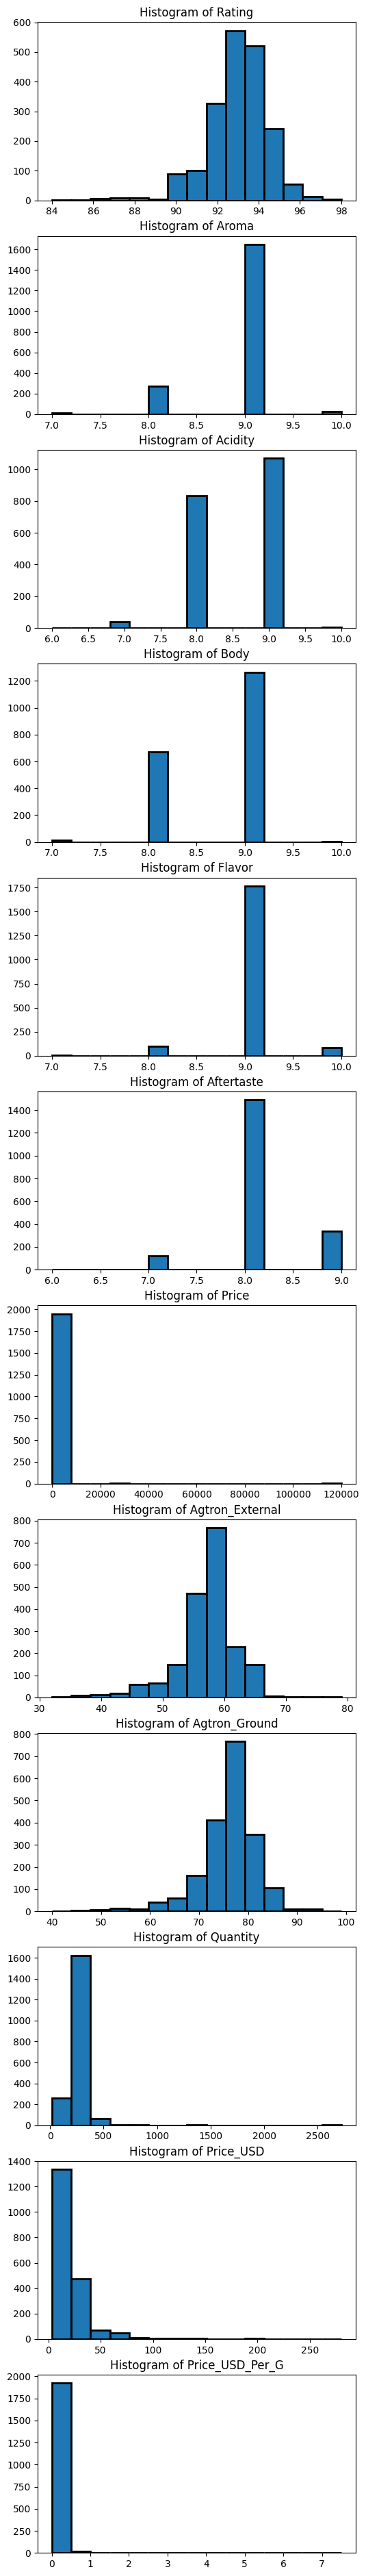

In [68]:
def hist_plotter(ax, data1, param_dict):
    out = ax.hist(data1, **param_dict)
    return out




numerical_columns = coffee.select_dtypes(include=['number']).columns

fig, axes = plt.subplots(nrows=len(numerical_columns), ncols=1, figsize=(6, 4*len(numerical_columns)))

for i, col in enumerate(numerical_columns):
    ax = axes[i]
    hist_plotter(ax, coffee[col], {'edgecolor':'black', 'linewidth':2, 'bins':15})
    ax.set_title(f'Histogram of {col}')

In [95]:
coffe.quercoffee[coffee['Price_USD_Per_G'] > 3]

,Rating,Roaster,Coffee_Name,Review_Date,Review_Description,Complete_Review_URL,Roaster_Website_URL,Roaster_Location,Origin,Roast_Level,Aroma,Acidity,Body,Flavor,Aftertaste,Blind_Assessment,Notes,Bottom_Line,Price,url,Agtron_External,Agtron_Ground,Currency,Quantity,Unit,Price_USD,Price_USD_Per_G,City,US_State,Country
801,95,Plat Coffee Roastery,Ninety Plus Panama Gesha Estate MS Joseph Brodsky 2307,2021-11-01,"Elegantly fruit-toned, juicy-sweet. Passion fruit, mango, sandalwood, rhododendron, cocoa nib in aroma and cup. Confidently sweet-tart structure with balanced acidity; plush, medium-bodied mouthfeel. Resonant, long, harmonious finish.",https://www.coffeereview.com/review/ninety-plus-panama-gesha-estate-ms-joseph-brodsky-2307/,NaN,"Hong Kong, China","Chiriqui Province, far western Panama",Medium-Light,9,9,9,9,9,"Elegantly fruit-toned, juicy-sweet. Passion fruit, mango, sandalwood, rhododendron, cocoa nib in aroma and cup. Confidently sweet-tart structure with balanced acidity; plush, medium-bodied mouthfeel. Resonant, long, harmonious finish.","Produced by Joseph Brodsky of Ninety Plus Estates entirely of the Gesha variety of Arabica, and processed by a proprietary method the producer refers to as “Jose Alfred’s Innovation.” Plat Coffee is a specialty roaster and café in Hong Kong. For more information, visit www.platcoffee.com.","A distinctively composed Panama Gesha cup that expresses balance and finesse, as well as restrained power with its fruit and floral dance.",280.0,https://www.coffeereview.com/review/ninety-plus-panama-gesha-estate-ms-joseph-brodsky-2307/,58,82,USD,70.0,grams,280.0,4.00,Hong Kong,NaN,China
1282,98,GK Coffee,GW01 Finca Sophia Olympus Geisha,2020-11-01,"Graceful, polished, exquisitely floral. Lavender, vanilla bean, bergamot, cocoa nib, lychee in aroma and cup. Delicate, vivid, multi-layered structure with elegantly sweet-tart acidity; very silky, buoyant mouthfeel. Elongated, richly floral, complex finish.",https://www.coffeereview.com/review/gw01-finca-sophia-olympus-geisha/,https://www.gkcoffee.com.tw,"Yilan, Taiwan","Nueva Suiza, Chiriquí, Panama",Medium-Light,10,10,9,10,9,"Graceful, polished, exquisitely floral. Lavender, vanilla bean, bergamot, cocoa nib, lychee in aroma and cup. Delicate, vivid, multi-layered structure with elegantly sweet-tart acidity; very silky, buoyant mouthfeel. Elongated, richly floral, complex finish.","This exceptional coffee was selected as the No. 1 coffee on Coffee Review’s list of the Top 30 Coffees of 2020. The coffee won first place in the washed Geisha category of the 2020 Best of Panama green coffee competition and was subsequently sold at auction for a price that broke all previous records for a green coffee. Produced at Finca Sophia entirely from trees of the celebrated Geisha variety of Arabica. This is a wet-processed or “washed” version, meaning the fruit skin and pulp were removed from the beans immediately after harvesting and before drying. GK Coffee is a nano-roastery in Yilan, Taiwan that offers both retail and wholesale coffee. Only sold via email request. For more information, visit www.gkcoffee.com.tw or email [email protected].","This Best of Panama winner also won us over with its layers of floral tones (lavender, violet, jasmine, freesia) delicately ensconced in cocoa and tropical fruit notes, all complicated by a lightly bracing bittersweet citrus.",5000.0,https://www.coffeereview.com/review/gw01-finca-sophia-olympus-geisha/,58,76,TWD,20.0,grams,150.0,7.50,Yilan,NaN,Taiwan
1637,97,Klatch Coffee,Panama Elida Geisha Natural 1029,2019-11-01,"Delicately and complexly aromatic, levitatingly high-toned. Dried passionfruit, aromatic orchid, frankincense, cocoa nib, tangerine zest in aroma and cup. Elegantly sweet structure with rich, vibrant acidity; lively, silky mouthfeel. The very long finish centers around frankincense-toned passionfruit and aromatic orchid with a cocoa throughline.",https://www.coffeereview.com/review/panama-elida-geisha-natural

In [110]:
coffee.groupby('Country')['Price_USD_Per_G'].mean().sort_values(ascending=False)

Country
Sydney                   0.650000
Japan                    0.447273
Big Island of Hawai’i    0.350000
China                    0.347097
Big Island of Hawai'i    0.310000
Hawai’i                  0.220000
Kauia                    0.210000
South Korea              0.210000
Kauai                    0.180000
Calfornia                0.160000
MInnesota                0.156364
Saskatchewan             0.155000
Oaxaca                   0.150000
Hawai'i                  0.124000
Maui                     0.118000
Taiwan                   0.117862
Honduras                 0.110000
United Arab Emirates     0.110000
D.C.                     0.107500
USA                      0.100084
Canada                   0.090000
New Taipei City          0.090000
Mexico                   0.090000
Taichung                 0.070000
 California              0.070000
Kenya                    0.070000
Colombia                 0.065000
England                  0.060000
Virginia and Floyd       0.060000
Ontari

In [111]:
coffee.Country.unique()

['USA', 'Taiwan', 'China', 'Big Island of Hawai'i', 'United Arab Emirates', ..., 'Kauia', 'Oaxaca', 'Chia-Yi', 'Uganda', 'Californiaa']
Length: 43
Categories (42, object): [' California', 'Alberta', 'Big Island of Hawai'i', 'Big Island of Hawai’i', ..., 'Uganda', 'United Arab Emirates', 'Virginia and Floyd', 'Washingto']